In [1]:
from csv import DictReader

with open('schweidtmann_train.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_train = [r for r in reader]
csv_file.close()

with open('schweidtmann_test.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_test = [r for r in reader]
csv_file.close()

print(len(rows_train), len(rows_test))

430 75


In [2]:
smiles_train, cn_train = [], []
smiles_test, cn_test = [], []

for sample in rows_train:
    if sample['Meas DCN'] != 'n.a.':
        smiles_train.append(sample[' SMILES'])
        cn_train.append([float(sample['Meas DCN'])])

for sample in rows_test:
    if sample['Meas DCN'] != 'n.a.':
        smiles_test.append(sample[' SMILES'])
        cn_test.append([float(sample['Meas DCN'])])

print(len(smiles_train), len(smiles_test))
print(len(cn_train), len(cn_test))

204 32
204 32


In [3]:
from graphchem.data import MoleculeGraph, MoleculeDataset
from graphchem.preprocessing import MoleculeEncoder

encoder = MoleculeEncoder(smiles_train)

encoding_train = encoder.encode_many(smiles_train)
encoding_test = encoder.encode_many(smiles_test)

graphs_train = [MoleculeGraph(e[0], e[1], e[2], cn_train[i]) for i, e in enumerate(encoding_train)]
graphs_test = [MoleculeGraph(e[0], e[1], e[2], cn_test[i]) for i, e in enumerate(encoding_test)]

ds_train = MoleculeDataset(graphs_train)
ds_test = MoleculeDataset(graphs_test)

print(len(ds_train), len(ds_test))

204 32


In [4]:
from graphchem.nn import MoleculeGCN
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from copy import deepcopy

train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=False)

atom_vocab_size, bond_vocab_size = encoder.vocab_sizes

model = MoleculeGCN(
    atom_vocab_size,
    bond_vocab_size,
    1,
    embedding_dim=64,
    n_messages=3,
    n_readout=5,
    readout_dim=128,
    dropout=0.0
)

init_lr = 0.001
lr_decay = 1e-7
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

train_losses = []
test_losses = []

_lowest_loss = 1e10
_best_weights = None
_best_epoch = 0

model.train()
for epoch in range(300):

    for g in optimizer.param_groups:
        g['lr'] = max(0, init_lr - (epoch * lr_decay))

    train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    test_loss = 0.0
    for batch in test_loader:
        pred, _, _ = model(batch)
        loss = F.mse_loss(pred, batch.y)
        test_loss += loss.detach().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if test_loss < _lowest_loss:
        _lowest_loss = test_loss
        _best_weights = deepcopy(model.state_dict())
        _best_epoch = epoch

    if epoch % 25 == 0:
        print(f'{epoch}: {train_loss} | {test_loss} | {_lowest_loss}')

model.load_state_dict(_best_weights)

model.eval()


c:\Users\tjkessler\.conda\envs\graphchem\Lib\site-packages\graphchem\data\structs.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(target).type(torch.float).reshape(1, len(target))


0: 61.74284714343501 | 795.7464592754841 | 795.7464592754841
25: 16.076067644007065 | 539.4501098524779 | 211.72807756066322
50: 9.909391216203279 | 321.94421773962677 | 157.69625366595574
75: 8.118035297767788 | 330.7769658435136 | 136.2820148949977
100: 4.977010726928711 | 126.15307217370719 | 126.15307217370719
125: 4.05040672713635 | 100.61456597534107 | 99.73899516346864
150: 3.098002835816028 | 86.74723993893713 | 86.25332806864753
175: 3.6347995739357146 | 89.04888651048532 | 80.64544883184135
200: 1.806081870022942 | 131.17046163489067 | 80.64544883184135
225: 1.318576272796182 | 93.5751825706102 | 80.64544883184135
250: 0.6833704616509232 | 95.6268904217286 | 69.75570413470268
275: 2.2236440836214553 | 115.3701195018366 | 69.75570413470268


MoleculeGCN(
  (emb_atom): Embedding(54, 64)
  (emb_bond): Embedding(38, 64)
  (atom_conv): GeneralConv(64, 64)
  (bond_conv): EdgeConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
  ))
  (readout): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
    )
    (1-4): 4 x Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (5): Sequential(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

<Figure size 640x480 with 0 Axes>

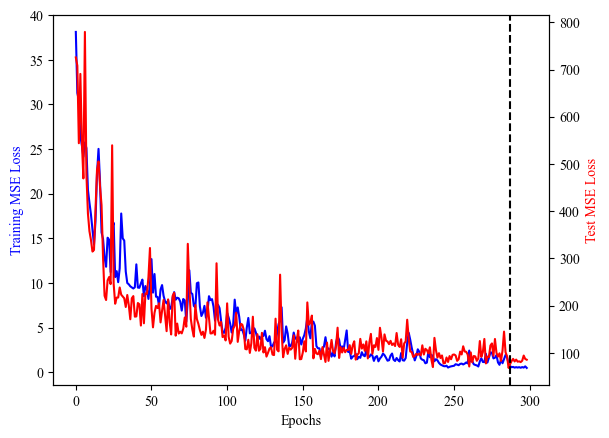

In [5]:
from matplotlib import pyplot as plt

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
ax.plot([i for i in range(len(train_losses[1:]))], train_losses[1:], color='blue')
ax.set_xlabel('Epochs')
ax.set_ylabel('Training MSE Loss', color='blue')
ax2 = ax.twinx()
ax2.plot([i for i in range(len(test_losses[1:]))], test_losses[1:], color='red')
ax2.set_ylabel('Test MSE Loss', color='red')
ax2.axvline(x=_best_epoch, color='black', linestyle='--')
plt.show()

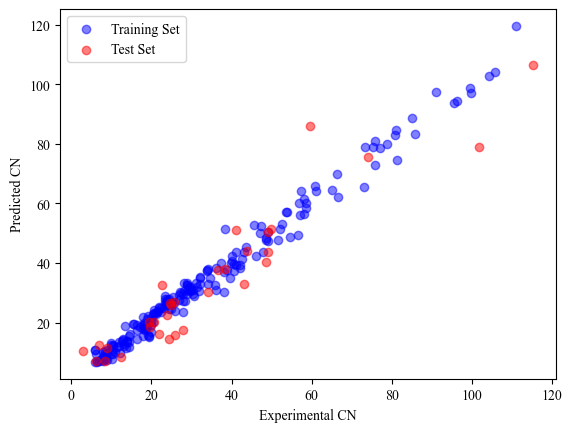

In [6]:
pred_train = [model(mol)[0].detach().numpy() for mol in ds_train]
pred_test = [model(mol)[0].detach().numpy() for mol in ds_test]
exp_train = [mol.y.numpy() for mol in ds_train]
exp_test = [mol.y.numpy() for mol in ds_test]

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(exp_train, pred_train, color='blue', label='Training Set', alpha=0.5)
plt.scatter(exp_test, pred_test, color='red', label='Test Set', alpha=0.5)
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.legend(loc='upper left')
plt.show()

In [7]:
from sklearn.metrics import mean_absolute_error, r2_score

e_test = [e[0] for e in exp_test]
p_test = [p[0] for p in pred_test]

print(f'Test MAE: {mean_absolute_error(e_test, p_test)}')
print(f'Test R2: {r2_score(e_test, p_test)}')

Test MAE: 5.552288055419922
Test R2: 0.892784930555452


In [8]:
test_preds = []

for i in range(40):

    print(f'{i}...')

    model = MoleculeGCN(
        atom_vocab_size,
        bond_vocab_size,
        1,
        embedding_dim=64,
        n_messages=3,
        n_readout=5,
        readout_dim=128,
        dropout=0.0
    )

    init_lr = 0.001
    lr_decay = 1e-7
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    _lowest_loss = 1e10
    _best_weights = None

    model.train()
    for epoch in range(300):

        for g in optimizer.param_groups:
            g['lr'] = max(0, init_lr - (epoch * lr_decay))

        for batch in train_loader:
            optimizer.zero_grad()
            pred, _, _ = model(batch)
            loss = F.mse_loss(pred, batch.y)
            loss.backward()
            optimizer.step()

        test_loss = 0.0
        for batch in test_loader:
            pred, _, _ = model(batch)
            loss = F.mse_loss(pred, batch.y)
            test_loss += loss.detach().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        if test_loss < _lowest_loss:
            _lowest_loss = test_loss
            _best_weights = deepcopy(model.state_dict())

    model.load_state_dict(_best_weights)
    model.eval()

    pred_test = [model(mol)[0].detach().numpy() for mol in ds_test]
    test_preds.append(pred_test)

0...


c:\Users\tjkessler\.conda\envs\graphchem\Lib\site-packages\graphchem\data\structs.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(target).type(torch.float).reshape(1, len(target))


1...
2...
3...
4...
5...
6...
7...
8...
9...
10...
11...
12...
13...
14...
15...
16...
17...
18...
19...
20...
21...
22...
23...
24...
25...
26...
27...
28...
29...
30...
31...
32...
33...
34...
35...
36...
37...
38...
39...


Test MAE: 5.288445472717285
Test R2: 0.9163198665286514


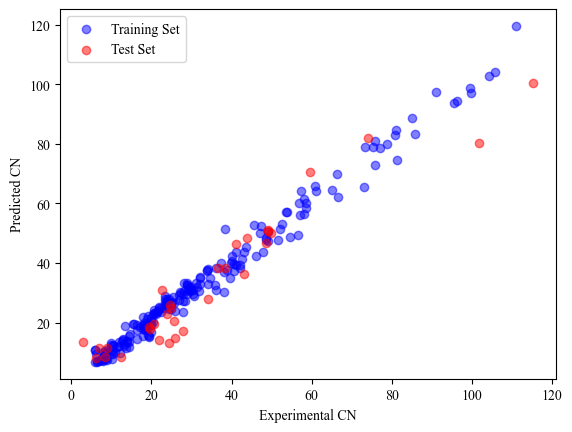

In [9]:
import numpy as np

ave_test_preds = np.mean(np.array(test_preds), axis=0)
test_preds_1d = [p[0][0] for p in ave_test_preds]

e_test = [e[0] for e in exp_test]

print(f'Test MAE: {mean_absolute_error(e_test, test_preds_1d)}')
print(f'Test R2: {r2_score(e_test, test_preds_1d)}')

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(exp_train, pred_train, color='blue', label='Training Set', alpha=0.5)
plt.scatter(exp_test, test_preds_1d, color='red', label='Test Set', alpha=0.5)
plt.xlabel('Experimental CN')
plt.ylabel('Predicted CN')
plt.legend(loc='upper left')
plt.show()